<a href="https://colab.research.google.com/github/christopherjneelankavil/malaria_detection_cnn/blob/main/malaria_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import RootMeanSquaredError, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall,AUC
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix

In [2]:
dataset, data_info = tfds.load('malaria', with_info = True, split = ['train'], shuffle_files = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.LUH7K9_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
data_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasit

In [4]:
for data in iter(dataset[0].take(5)):
    print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [5]:
def splits(dataset, TRAIN_RATIO, TEST_RATIO, VAL_RATIO):

    DATASET_SIZE = len(dataset)

    # train split
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

    # test and val split together
    test_val_split = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))

    # val dataset split
    val_dataset = test_val_split.take(int(VAL_RATIO * DATASET_SIZE))

    # test dataset split
    test_dataset = test_val_split.skip(int(VAL_RATIO * DATASET_SIZE))

    #return values
    return train_dataset, val_dataset, test_dataset


In [6]:
# test code

TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, TEST_RATIO, VAL_RATIO)

print(
    list(train_dataset.take(1).as_numpy_iterator()),
    list(test_dataset.take(1).as_numpy_iterator()),
    list(val_dataset.take(1).as_numpy_iterator())
)

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), np.int64(0))] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0,

## Data visualization

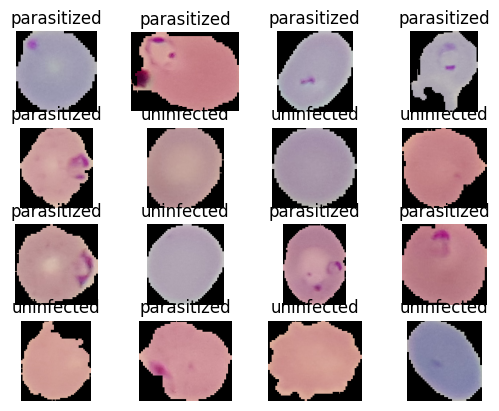

In [7]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    axis = plt.subplot(4,4, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(data_info.features['label'].int2str(label))

## Data preprocessing

In [8]:
IMAGE_SIZE = 224

In [9]:
def resize_and_rescale(image, label):
    return tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0, label

In [10]:
train_dataset = train_dataset.map(resize_and_rescale)
val_dataset = val_dataset.map(resize_and_rescale)
test_dataset = test_dataset.map(resize_and_rescale)

In [11]:
for image, label in train_dataset.take(1):
    print(f"Image: \n{image}\n\nLabel: {label}")
    print(image.dtype)

Image: 
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]

Label: 1
<dtype: 'float32'>


In [12]:
## prefetching

train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

## Model creation

In [14]:
# LeNet architecture - Sequential

model = tf.keras.Sequential([

    #input layer
    InputLayer(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)),

    #convolutional layers
    Conv2D(filters = 6, kernel_size = 3, activation = 'relu', padding = 'valid', strides= 1),

    # BatchNormalization
    BatchNormalization(),

    #max pooling layer
    MaxPool2D(pool_size = 2, strides = 2),

    # convolutional layers
    Conv2D(filters = 16, kernel_size=3, activation='relu', padding = 'valid', strides = 1),

    # BatchNormalization
    BatchNormalization(),

    # max pooling layer
    MaxPool2D(pool_size = 2, strides = 2),

    # Flatten layer
    Flatten(),

    # Dense layers
    Dense(100, activation = 'relu'),
    # BatchNormalization
    BatchNormalization(),

    Dense(10, activation = 'relu'),
    # BatchNormalization
    BatchNormalization(),

    # Output
    Dense(1, activation = 'sigmoid')

])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

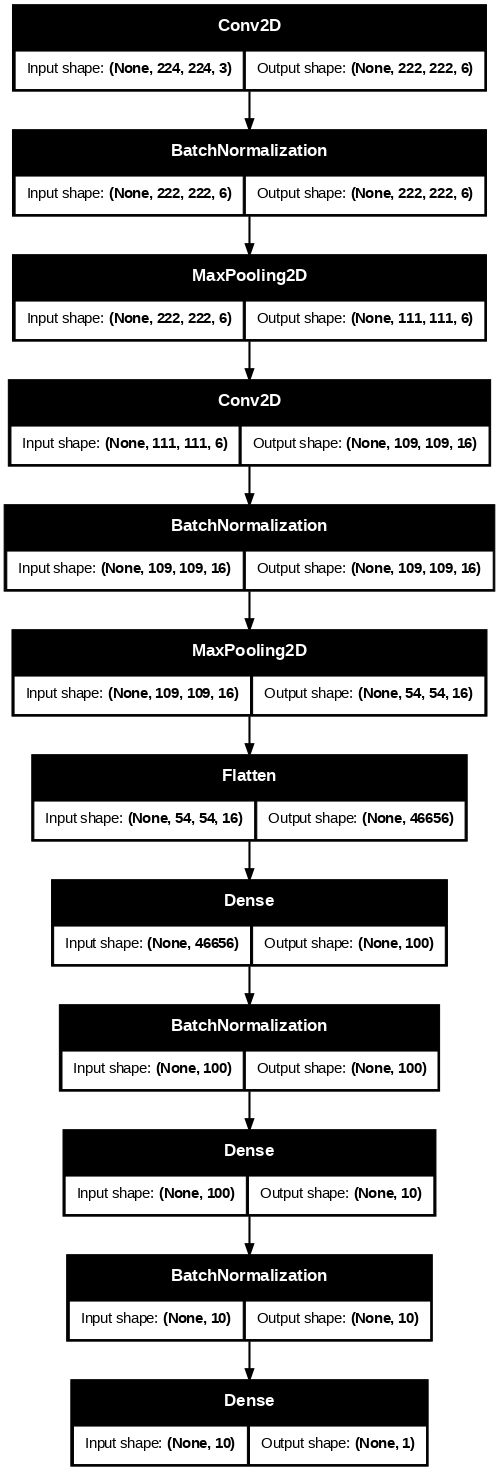

In [15]:
tf.keras.utils.plot_model(model, show_shapes = True, dpi = 75)

### Functional API

In [16]:
# Functional API - Lenet Model

from os import name
func_input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name='Input image')


# Feature extraction
## convolution layers
x = Conv2D(filters=6, kernel_size=3, activation='relu', padding='valid', strides=1)(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='valid', strides=1)(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

#flattened layer
x = Flatten()(x)


# Dense layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)


# Output layers
func_output = Dense(1, activation='sigmoid')(x)

func_model = Model(func_input, func_output, name='Functional_API_model')
func_model.summary()

Model: "Functional_API_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

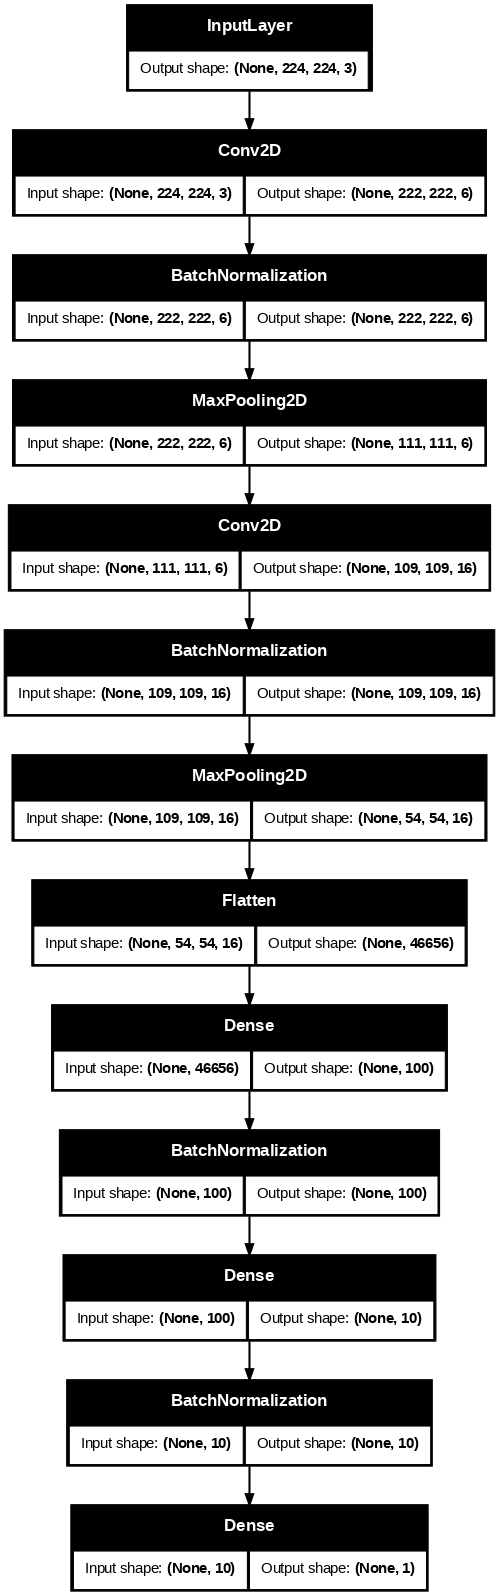

In [17]:
tf.keras.utils.plot_model(func_model, show_shapes=True, dpi=75)

#### Another method for functional api

In [18]:
# Feature extraction

func_input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, padding='valid', activation='relu', strides=1)(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu', strides=1)(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extraction_model = Model(func_input, output, name='Feature_extraction_model')
feature_extraction_model.summary()

Model: "Feature_extraction_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [19]:
# Functional API - Lenet Model

from os import name
func_input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name='Input image')


# Feature extraction
x = feature_extraction_model(func_input)

#flattened layer
x = Flatten()(x)


# Dense layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)


# Output layers
func_output = Dense(1, activation='sigmoid')(x)

func_model = Model(func_input, func_output, name='Functional_API_model')
func_model.summary()

Model: "Functional_API_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Feature_extraction_model        │ (None, 54, 54, 16)     │         1,136 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

#### Yet another method combining sequential and functional

In [20]:
sequential_model_feature_extraction = tf.keras.Sequential([
    InputLayer(shape = (IMAGE_SIZE, IMAGE_SIZE, 3)),

    #Convoulution layers
    Conv2D(filters = 6, kernel_size = 3, activation = 'relu', padding = 'valid', strides = 1),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'valid', strides = 1),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides = 2)
])

sequential_model_feature_extraction.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [21]:
func_input_to_sequential = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name = 'Input image to sequential model')

x = sequential_model_feature_extraction(func_input_to_sequential)

x = Flatten()(x)

x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = 'sigmoid')(x)

func_model_using_sequential = Model(func_input_to_sequential, func_output, name = 'Functional_model_using_sequential')
func_model_using_sequential.summary()

Model: "Functional_model_using_sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input image to sequential model │ (None, 224, 224, 3)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 54, 54, 16)     │         1,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

## Model Subclassing

In [22]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, activation, padding, pool_size, strides):
        super(FeatureExtractor, self).__init__()

        self.conv1 = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding, strides = strides)
        self.batch_norm1 = BatchNormalization()
        self.max_pool1 = MaxPool2D(pool_size=pool_size, strides = strides)
        self.conv2 = Conv2D(filters=(filters+10), kernel_size=kernel_size, activation=activation, padding=padding, strides = strides)
        self.batch_norm2 = BatchNormalization()
        self.max_pool2 = MaxPool2D(pool_size=pool_size, strides = strides)


    def call(self, x):

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.max_pool2(x)


        return x

feature_sub_classed = FeatureExtractor(filters = 6, kernel_size = 3, activation = 'relu', padding = 'valid', pool_size = 2, strides = 2)

In [23]:
func_input_to_model_subclass = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name = 'Input image to subclass model')

x = feature_sub_classed(func_input_to_model_subclass)

x = Flatten()(x)

x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = 'sigmoid')(x)

func_model_using_sequential = Model(func_input_to_model_subclass, func_output, name = 'Functional_model_using_subclass')
func_model_using_sequential.summary()

Model: "Functional_model_using_subclass"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input image to subclass model   │ (None, 224, 224, 3)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor               │ (None, 13, 13, 16)     │         1,136 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │       270,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,097 (1.04 MB)

 Trainable params: 272,833 (1.04 MB)

 Non-trainable params: 264 (1.03 KB)

#### Another method for model subclassing

In [24]:
class FeatureExtractorLenet(Model):

    def __init__(self, filters, kernel_size, activation, padding, pool_size, strides):
        super(FeatureExtractorLenet, self).__init__()

        self.feature_extractor = FeatureExtractor(filters = filters, kernel_size = kernel_size, activation = activation, padding = padding, pool_size = pool_size, strides = strides)

        self.flatten = Flatten()

        self.dense1 = Dense(100, activation = 'relu')
        self.batch1 = BatchNormalization()

        self.dense2 = Dense(10, activation = 'relu')
        self.batch2 = BatchNormalization()

        self.output_layer = Dense(1, activation = 'sigmoid') # Changed variable name to avoid conflict

    def call(self,x):
        x = self.feature_extractor(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.batch1(x)

        x = self.dense2(x)
        x = self.batch2(x)

        return self.output_layer(x)


lenet_sub_classed = FeatureExtractorLenet(filters = 6, kernel_size = 3, activation = 'relu', padding = 'valid', pool_size = 2, strides = 2)
lenet_sub_classed.summary()

Model: "feature_extractor_lenet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor_1             │ ?                      │   0 (unbuilt) │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Custom Layers

In [25]:
class NeuralDense(Layer):

    def __init__(self, output_units, activation):
        super(NeuralDense, self).__init__()
        self.output_units = output_units
        self.activation = activation

    def build(self, input_features_shape):
        self.weight = self.add_weight(shape = (input_features_shape[-1], self.output_units), trainable = True, initializer = "random_normal")
        self.bias = self.add_weight(shape = (self.output_units,), trainable = True, initializer = "random_normal")

    def call(self, input_features):

        val = tf.matmul(input_features, self.weight) + self.bias

        if self.activation == 'relu' :
            return tf.nn.relu(val)
        elif self.activation == 'sigmoid':
            return tf.math.sigmoid(val)
        else:
            return val


In [26]:
from threading import active_count
# adding a sequenctial api here for the custom dense layer

sequential_model_for_custom_dense_layer = tf.keras.Sequential([
    InputLayer(shape = (IMAGE_SIZE, IMAGE_SIZE,3)),

    # feature extraction convolution layers
    Conv2D(filters = 6, kernel_size = 3, activation = 'relu', padding = 'valid', strides = 1),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    # second conv layer, batchnorm and maxpool for feature extraction
    Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'valid', strides = 1),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    #flatten
    Flatten(),

    # dense layers for decision making using custom dense layers from NeuralDense
    NeuralDense(100, activation = 'relu'),
    BatchNormalization(),

    NeuralDense(10, activation = 'relu'),
    BatchNormalization(),

    #output layer
    NeuralDense(1, activation = 'sigmoid')
])

sequential_model_for_custom_dense_layer.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neural_dense (NeuralDense)      │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neural_dense_1 (NeuralDense)    │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neural_dense_2 (NeuralDense)    │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

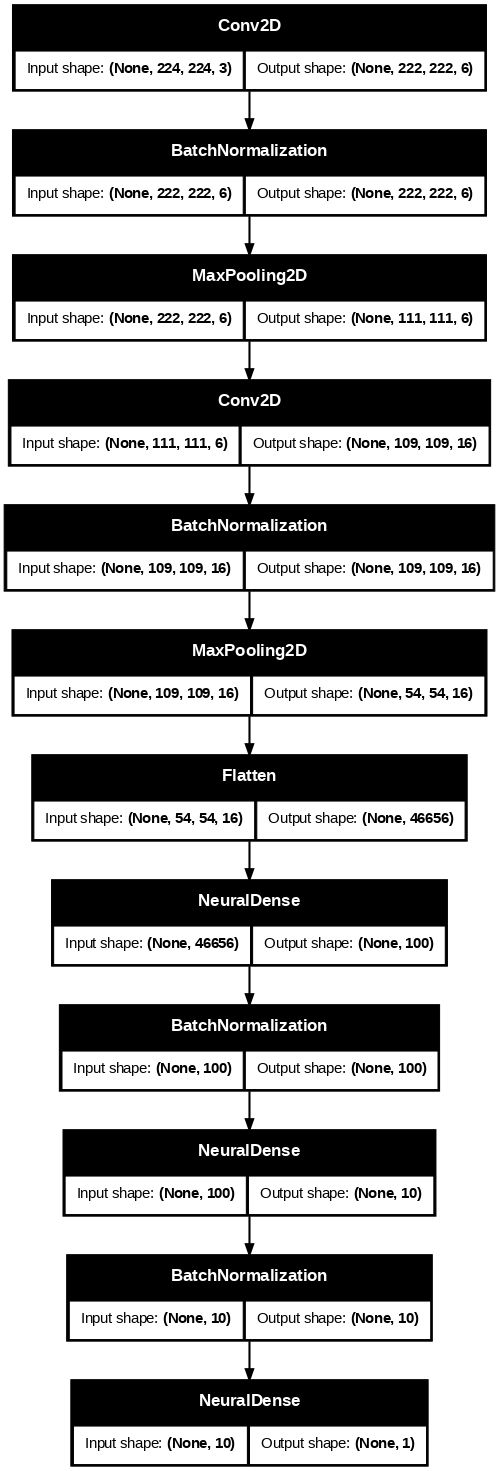

In [27]:
tf.keras.utils.plot_model(sequential_model_for_custom_dense_layer, show_shapes = True, dpi = 75)

## Model Compiling

In [37]:
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    TruePositives(name = 'true_positives'),
    TrueNegatives(name = 'true_negatives'),
    FalsePositives(name = 'false_positives'),
    FalseNegatives(name = 'false_negatives'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    AUC(name = 'auc')
]

In [38]:
sequential_model_for_custom_dense_layer.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = BinaryCrossentropy(),
    metrics = metrics
)

## Model Training

In [39]:
history = sequential_model_for_custom_dense_layer.fit(
    train_dataset,
    epochs = 5,
    verbose = 1,
    validation_data = val_dataset
)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.9693 - auc: 0.9945 - false_negatives: 135.2551 - false_positives: 195.8623 - loss: 0.0847 - precision: 0.9650 - recall: 0.9743 - true_negatives: 5322.8955 - true_positives: 5401.9346 - val_accuracy: 0.8871 - val_auc: 0.9530 - val_false_negatives: 138.0000 - val_false_positives: 173.0000 - val_loss: 0.2796 - val_precision: 0.8784 - val_recall: 0.9006 - val_true_negatives: 1194.0000 - val_true_positives: 1250.0000
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9767 - auc: 0.9973 - false_negatives: 101.4217 - false_positives: 154.4159 - loss: 0.0616 - precision: 0.9723 - recall: 0.9816 - true_negatives: 5364.3130 - true_positives: 5435.7969 - val_accuracy: 0.9372 - val_auc: 0.9761 - val_false_negatives: 43.0000 - val_false_positives: 130.0000 - val_loss: 0.2260 - val_precision: 0.9119 - val_recall: 0.9690 - val_true_negatives: 1237.0000 - val_true_positives: 1345.0000
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━

## Results

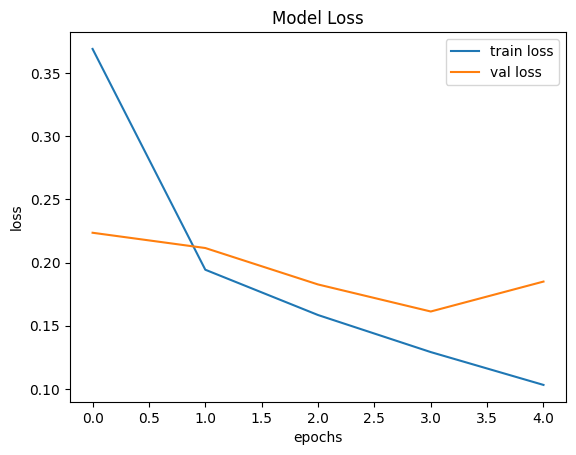

In [32]:
plt.title("Model Loss")
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')

plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

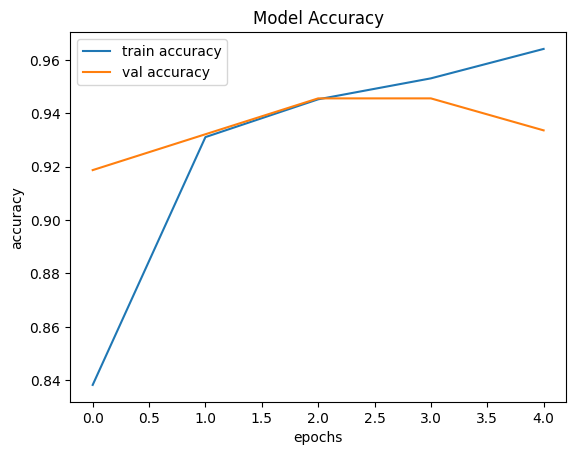

In [33]:
plt.title("Model Accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['train accuracy', 'val accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## Model evaluation and testing

In [41]:
sequential_model_for_custom_dense_layer.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9214 - auc: 0.9659 - false_negatives: 56.3295 - false_positives: 54.0455 - loss: 0.3198 - precision: 0.9257 - recall: 0.9182 - true_negatives: 656.1818 - true_positives: 656.4659


[0.32722344994544983,
 0.9220166802406311,
 1256.0,
 1286.0,
 107.0,
 108.0,
 0.9214966893196106,
 0.9208211302757263,
 0.9650493860244751]

##Confusion Matrix

In [42]:
labels = []
inputs = []

for X,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inputs.append(X)

In [46]:
all_labels = np.concatenate(labels, axis=0)
all_inputs = np.concatenate(inputs, axis=0)

print(f"Total number of labels: {len(all_labels)}")
print(f"Shape of all inputs: {all_inputs.shape}")

Total number of labels: 2757
Shape of all inputs: (2757, 224, 224, 3)


In [51]:
predicted = sequential_model_for_custom_dense_layer.predict(all_inputs)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [52]:
print(predicted.shape)

(2757, 1)


In [60]:
THRESHOLD = 0.5

conf_matrix = confusion_matrix(all_labels, predicted > THRESHOLD)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1289  107]
 [ 107 1254]]


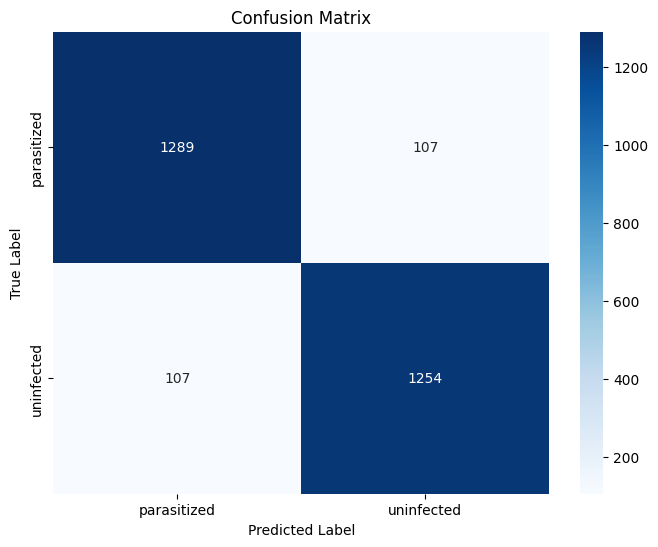

In [61]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data_info.features['label'].names, yticklabels=data_info.features['label'].names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def parasite_or_not(value):
    if value < 0.5:
        print("Parasite not detected")
    else:
        print("Parasite detected")

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Parasite not detected


Parasite detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
Parasite detected
Parasite detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Parasite detected
Parasite not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Parasite not detected
Parasite detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Parasite detected
Parasite not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Parasite not detected
Parasite detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Parasite detected
Parasite not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Parasite not detected
Parasite not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Parasite not detected
Parasite not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Parasite not detected


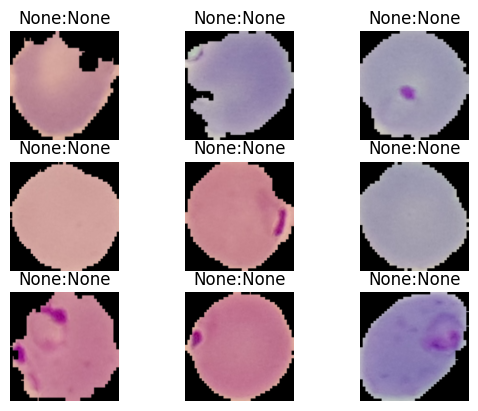

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

    axis = plt.subplot(3,3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
    plt.axis('off')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,004,365 (53.42 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 9,336,068 (35.61 MB)

## Saving model

In [ ]:
model.save('malaria_detection_model.keras')